### Is gas more expensive in poor neighborhoods?

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
%matplotlib inline

In [127]:
def _parse(formatted_row):
    s= str(formatted_row[1])
    start = s.find("$") + 1
    end = start + 4
    price = s[start:end]
    while not price[-1].isdigit():
        price = price[:len(price)-1]
    price = float(price)
    start = s.find("located at") + len("located at") + 1
    end = s.find("border") - 2
    address = s[start:end]
    return price, address

def _extract_zip(address):
    try:
        zp = int(address.strip()[-5:])
    except ValueError:
        zp = -1
    return zp
        

def get_gas_prices(city, state, npages):
    urls = map(lambda x: "http://www.gaspricewatch.com/%s/%s/gas-prices/page-%d/2.htm" % \
               (state, city, x), range(1, npages+1))
    responses = [requests.get(url) for url in urls]
    soups = [BeautifulSoup(page.content, "lxml") for page in responses]
    try:
        summary = " ".join(city.split("-")) + ", " + state[0:2] + " Lowest Regular Gas Prices"

        rows=list()
        for i in xrange(len(soups)):
            tbl = soups[i].find("table", summary=summary)
            for row in tbl.findAll("tr"):
                rows.append(row)
        header_idx = [0 + 21*k for k in xrange(0, npages)]
        rows = [rows[i] for i in xrange(len(rows)) if i not in header_idx]

        formatted_rows = list()
        for row in rows:
            formatted_rows.append(row.findAll("td"))
        gas_prices = pd.DataFrame(map(_parse, formatted_rows))
        gas_prices.rename(columns={0:"gas_price", 1:"address"}, inplace=True)
        gas_prices["ZIP5"] = map(_extract_zip, gas_prices.address)
        return gas_prices
    except ValueError:
        return soups

In [71]:
gas_prices_LA = get_gas_prices("Los-Angeles", "CA-california", 15)

Los Angeles, CA Lowest Regular Gas Prices


In [72]:
gas_prices_OAK = get_gas_prices("Oakland", "CA-california", 4)
gas_prices_OAK.head()

Oakland, CA Lowest Regular Gas Prices
   gas_price                               address   ZIP5
0       2.53         720 High St,Oakland, CA,94601  94601
1       2.55  2200 Telegraph Ave,Oakland, CA,94612  94612
2       2.57  566 Hegenberger Rd,Oakland, CA,94621  94621
3       2.57   3132 Beaumont Ave,Oakland, CA,94602  94602
4       2.57       3130 35th Ave,Oakland, CA,94619  94619


In [128]:
gas_prices_Houston = get_gas_prices("Houston", "TX-Texas", 41)
gas_prices_Houston.head()

,gas_price,address,ZIP5
0,1.48,"1710 FM-528,Houston, TX,77073",77073
1,1.55,"7805 S Sam Houston Pkwy E,Houston, TX,77075",77075
2,1.55,"7745 S Sam Houston Pkwy W,Houston, TX,77085",77085
3,1.56,"9705 Telephone Rd (#A),Houston, TX,77075",77075
4,1.56,"9105 Telephone Rd,Houston, TX,77075",77075


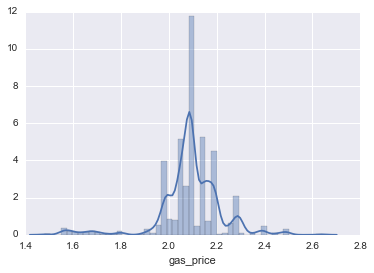

In [129]:
sns.distplot(gas_prices_Houston.gas_price)

In [47]:
# get median income from Census
census_data = pd.read_csv("/Users/timothysweetser/git/gas_prices/raw_data/ACS_14_5YR_DP03_with_ann.csv",
                                   usecols=["HC01_VC85", "GEO.id2", "GEO.display-label"],
                          low_memory=False)
census_data.rename(columns=dict(zip(census_data.columns, census_data.ix[0, :])), inplace=True)
census_data.rename(columns={census_data.columns[-1]:"median_income"}, inplace=True)
census_data.drop([0], axis=0, inplace=True)
census_data["Id2"] = census_data["Id2"].astype(int)
census_data["median_income"] = [x if x != "-" else np.nan for x in census_data["median_income"]]
census_data["median_income"] = census_data["median_income"].astype(float)
census_data.head()

,Id2,Geography,median_income
1,89010,ZCTA5 89010,35000.0
2,89019,ZCTA5 89019,37632.0
3,89060,ZCTA5 89060,40726.0
4,89061,ZCTA5 89061,55096.0
5,89439,ZCTA5 89439,59275.0


In [48]:
# Zip uniquely identifies each row
census_data.Id2.nunique() == len(census_data)

True

In [49]:
gas_prices = gas_prices.merge(census_data, 'inner', left_on="ZIP5", right_on="Id2")
gas_prices = gas_prices[gas_prices["median_income"] < 110000] 
# exclude 1 very high income ZIP code

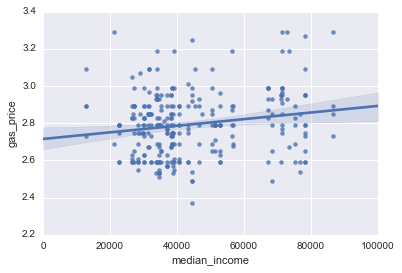

In [50]:
sns.regplot("median_income", "gas_price", data=gas_prices)

In [51]:
pearsonr(gas_prices["median_income"], gas_prices["gas_price"])

(0.17772278027306065, 0.0025575217583544011)

In [52]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [54]:
mod = ols("gas_price ~ median_income", data=gas_prices).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:              gas_price   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     9.263
Date:                Sat, 04 Jun 2016   Prob (F-statistic):            0.00256
Time:                        15:16:43   Log-Likelihood:                 107.88
No. Observations:                 286   AIC:                            -211.8
Df Residuals:                     284   BIC:                            -204.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         2.7153      0.028     98.526

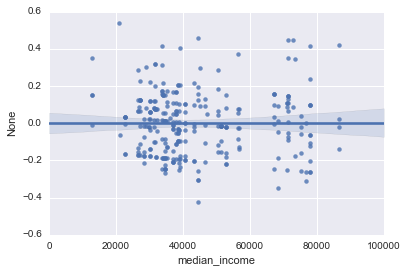

In [58]:
sns.regplot(gas_prices["median_income"], mod.resid)